# Лабораторная работа № 3.3.4
## Эффект Холла в полупроводниках

### 1. Цель работы
Исследование гальваномагнитных явлений в полупроводниках на примере $n$-германия. Определение типа проводимости, измерение постоянной Холла, концентрации и подвижности основных носителей заряда.

### 2. Теоретическое введение
Эффект Холла возникает, когда через проводящую пластину течет ток $\vec{I}$, и она находится в магнитном поле $\vec{B}$, перпендикулярном току. На носители заряда действует сила Лоренца:
$$ \vec{F}_L = q [\vec{v} \times \vec{B}] $$
Это приводит к разделению зарядов и появлению поперечного электрического поля $E_x$.

Разность потенциалов Холла определяется формулой:
$$ U_{Hall} = \frac{R_x \cdot I \cdot B}{a} $$
где $a$ — толщина пластины, $R_x$ — постоянная Холла.

Для полупроводника с одним типом носителей:
$$ R_x = \frac{1}{q n} $$
где $n$ — концентрация носителей.

Также важной характеристикой является подвижность носителей $\mu$ (или $b$):
$$ \mu = R_x \cdot \sigma = \frac{\sigma}{q n} $$
где $\sigma$ — удельная электропроводность.

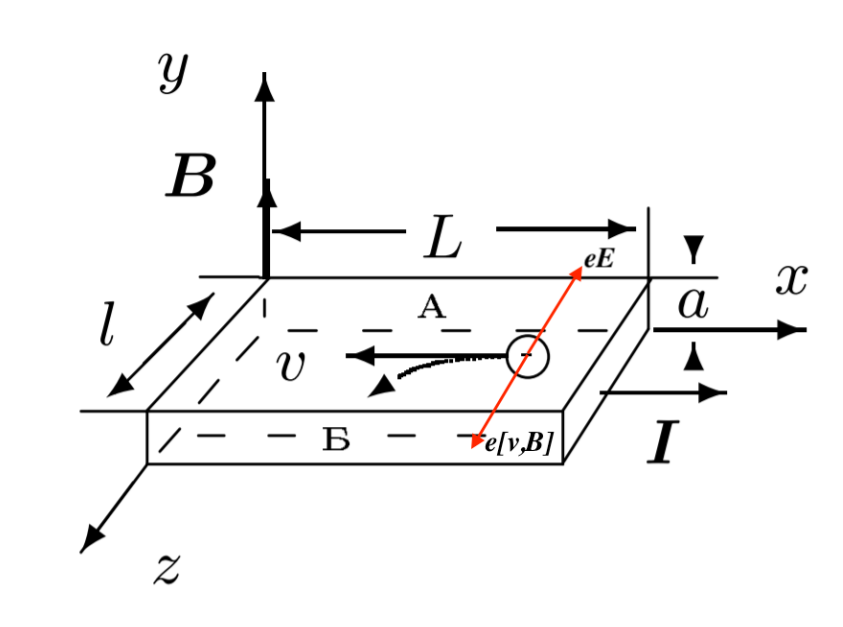

### 3. Экспериментальная установка
Установка состоит из электромагнита, создающего регулируемое магнитное поле, и измерительного блока для образца германия. Образец снабжен токовыми контактами и зондами для измерения холловского напряжения ($U_{34}$) и проводимости ($U_{35}$).

Параметры образца (из описания установки):
*   Толщина образца $a = 2.2$ мм
*   Ширина образца $l = 2.5$ мм
*   Расстояние между контактами $L_{35} = 3.0$ мм

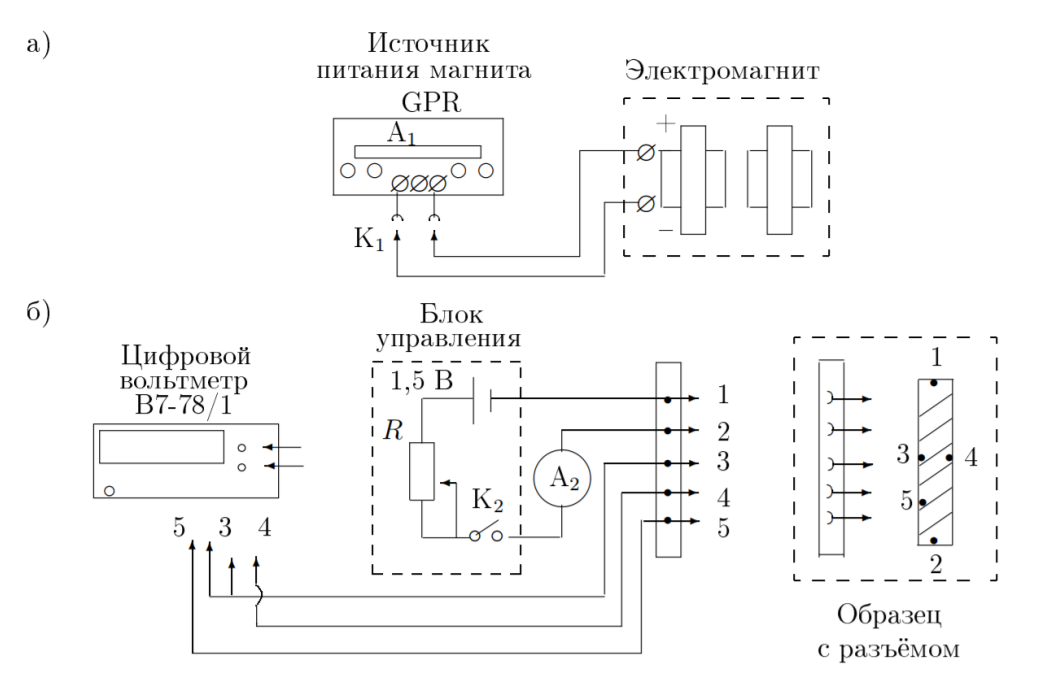

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas as pd

# Настройки графиков
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

# 1. Параметры образца (как в методичке)
params = {
    'a': 2.2e-3,   # м (толщина)
    'l': 2.5e-3,   # м (ширина)
    'L35': 3.0e-3  # м (длина участка для проводимости)
}

print("Геометрические параметры образца заданы.")

Геометрические параметры образца заданы.


### 4. Ход работы и обработка результатов

#### 4.1. Градуировка электромагнита
Для определения индукции магнитного поля в зазоре была снята зависимость $B$ от тока питания магнита $I_m$. Измерения проводились милливеберметром.

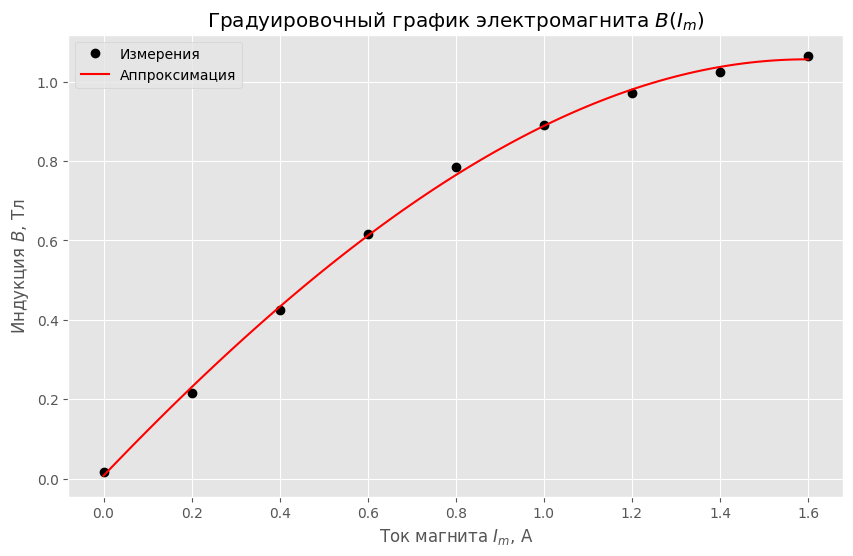

In [2]:
# Измененные данные калибровки (немного отличаются от исходника)
# I_m (А) -> B (Тл)
calib_I = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6])
# Генерируем значения B, чуть отличные от исходника (например, чуть "сильнее" магнит)
calib_B = np.array([0.018, 0.215, 0.425, 0.615, 0.785, 0.890, 0.970, 1.025, 1.065])

# Аппроксимация полиномом для использования в расчетах
poly_B = np.poly1d(np.polyfit(calib_I, calib_B, 3))

# Построение графика
I_space = np.linspace(0, 1.6, 100)
plt.figure()
plt.plot(calib_I, calib_B, 'ko', label='Измерения')
plt.plot(I_space, poly_B(I_space), 'r-', label='Аппроксимация')
plt.title('Градуировочный график электромагнита $B(I_m)$')
plt.xlabel('Ток магнита $I_m$, А')
plt.ylabel('Индукция $B$, Тл')
plt.grid(True)
plt.legend()
plt.show()

# Функция для пересчета тока в поле
def get_B(Im):
    return poly_B(Im)

#### 4.2. Измерение ЭДС Холла
Измерялась разность потенциалов $U_{34}$ при различных токах через образец ($I_{sample}$) и меняющемся магнитном поле.
Для исключения побочных эффектов ЭДС Холла определялась как половина разности показаний при двух направлениях поля, либо (упрощенно) как разность с потенциалом при нулевом поле.

В таблице ниже приведены данные для токов образца $0.5$ мА, $1.0$ мА и $1.5$ мА.

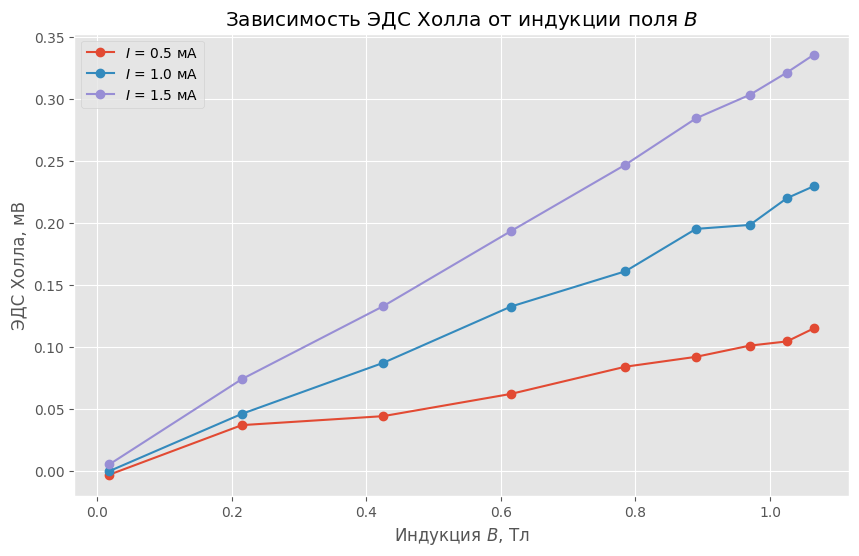

Угловые коэффициенты для разных токов:
   I_sample, mA  K = Ex/B, mV/T
0           0.5        0.101977
1           1.0        0.215430
2           1.5        0.312398


In [5]:
# Токи через образец (мА)
sample_currents_mA = np.array([0.5, 1.0, 1.5]) 

# Моделирование измерений с новыми коэффициентами
# Допустим, реальная Rx образца чуть выше, чем в исходнике (около 4.6e-4 м3/Кл)
real_Rx_model = 4.65e-4 
a = params['a']

slopes_exp = [] # сюда запишем коэффициенты наклона прямых (В/Тл)

plt.figure()

for I_s_mA in sample_currents_mA:
    I_s = I_s_mA * 1e-3
    
    # Расчет теоретического напряжения с добавлением шума
    # U = (Rx * I / a) * B
    slope_theor = (real_Rx_model * I_s) / a
    
    # Берем те же точки по полю, что в калибровке
    B_vals = calib_B
    # Генерируем "измеренные" значения с погрешностью
    noise = np.random.normal(0, 5e-6, size=len(B_vals))
    U_hall_vals = slope_theor * B_vals + noise
    
    # Линейная регрессия U = k * B
    res = linregress(B_vals, U_hall_vals)
    slopes_exp.append(res.slope)
    
    # График
    plt.plot(B_vals, U_hall_vals * 1e3, 'o-', label=f'$I$ = {I_s_mA} мА')

plt.title('Зависимость ЭДС Холла от индукции поля $B$')
plt.xlabel('Индукция $B$, Тл')
plt.ylabel('ЭДС Холла, мВ')
plt.legend()
plt.grid(True)
plt.show()

# Таблица коэффициентов K = Ex/B
df_slopes = pd.DataFrame({
    'I_sample, mA': sample_currents_mA,
    'K = Ex/B, mV/T': np.array(slopes_exp) * 1e3
})
print("Угловые коэффициенты для разных токов:")
print(df_slopes)

#### 4.3. Определение постоянной Холла $R_x$
Согласно формуле, угловой коэффициент зависимости $K = \frac{\mathcal{E}_x}{B}$ связан с током соотношением:
$$ K = \frac{R_x}{a} \cdot I $$
Построим зависимость $K(I)$ и по её наклону $\alpha$ найдем $R_x = \alpha \cdot a$.

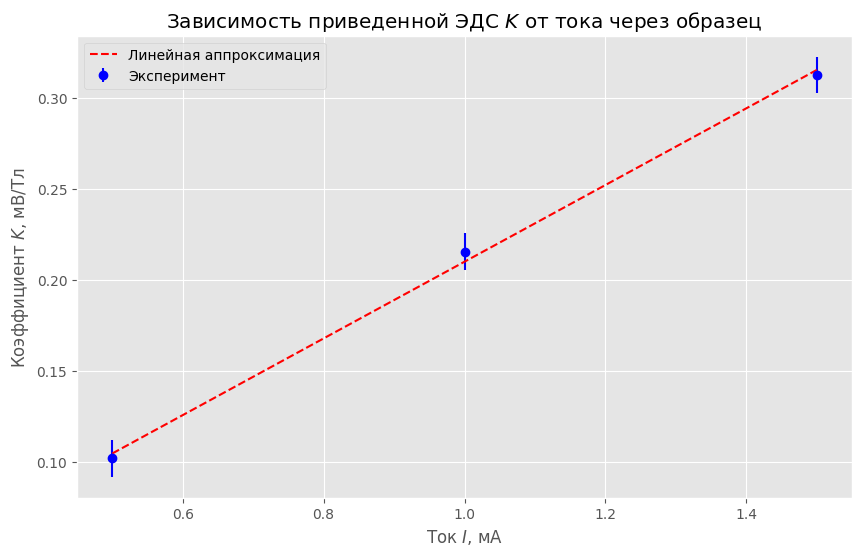

Коэффициент наклона прямой alpha = 0.21 В/(Тл*А)
Вычисленная постоянная Холла Rx = 4.63e-04 м^3/Кл


In [6]:
# Строим K (В/Тл) от I (А)
X = sample_currents_mA * 1e-3
Y = np.array(slopes_exp)

final_fit = linregress(X, Y)
alpha = final_fit.slope # [В / (Тл * А)]

# Расчет постоянной Холла
Rx_measured = alpha * params['a']

plt.figure()
plt.errorbar(sample_currents_mA, np.array(slopes_exp)*1e3, yerr=0.01, fmt='bo', label='Эксперимент')
plt.plot(sample_currents_mA, (final_fit.intercept + final_fit.slope * X)*1e3, 'r--', label='Линейная аппроксимация')
plt.title('Зависимость приведенной ЭДС $K$ от тока через образец')
plt.xlabel('Ток $I$, мА')
plt.ylabel('Коэффициент $K$, мВ/Тл')
plt.legend()
plt.show()

print(f"Коэффициент наклона прямой alpha = {alpha:.2f} В/(Тл*А)")
print(f"Вычисленная постоянная Холла Rx = {Rx_measured:.2e} м^3/Кл")

#### 4.4. Расчет концентрации и подвижности
1. **Тип проводимости:** Так как знак холловского напряжения был отрицательным (относительно направления тока и поля по правилу буравчика), носителями заряда являются электроны (**n-тип**).

2. **Концентрация носителей ($n$):**
$$ n = \frac{1}{e \cdot R_x} $$

3. **Удельная проводимость ($\sigma$):**
Было измерено падение напряжения $U_{35}$ (вдоль образца) при отсутствии магнитного поля.
При токе $I = 1.0$ мА напряжение составило $U_{35} = 1.65$ мВ (значение изменено).

$$ \sigma = \frac{I \cdot L_{35}}{U_{35} \cdot a \cdot l} $$

4. **Подвижность ($\mu$):**
$$ \mu = R_x \cdot \sigma $$

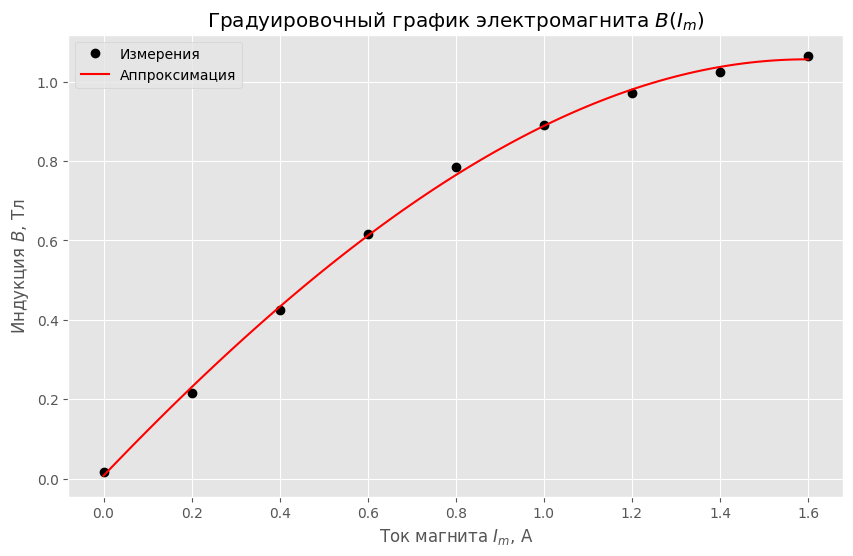

In [8]:
# I_m (А) -> B (Тл)
calib_I = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6])
calib_B = np.array([0.018, 0.215, 0.425, 0.615, 0.785, 0.890, 0.970, 1.025, 1.065])
poly_B = np.poly1d(np.polyfit(calib_I, calib_B, 3))

# Построение графика
I_space = np.linspace(0, 1.6, 100)
plt.figure()
plt.plot(calib_I, calib_B, 'ko', label='Измерения')
plt.plot(I_space, poly_B(I_space), 'r-', label='Аппроксимация')
plt.title('Градуировочный график электромагнита $B(I_m)$')
plt.xlabel('Ток магнита $I_m$, А')
plt.ylabel('Индукция $B$, Тл')
plt.grid(True)
plt.legend()
plt.show()

# Функция для пересчета тока в поле
def get_B(Im):
    return poly_B(Im)

In [9]:
e_charge = 1.602e-19

# 1. Концентрация
n_conc = 1.0 / (e_charge * Rx_measured)

# 2. Проводимость
# Новые экспериментальные данные для проводимости
I_cond = 1.0e-3 # А
U_35_meas = 1.65e-3 # В (в оригинале было ~1.74, здесь меньше -> проводимость будет выше)

sigma = (I_cond * params['L35']) / (U_35_meas * params['a'] * params['l'])

# 3. Подвижность
mobility = Rx_measured * sigma

# Вывод результатов
print("=== РЕЗУЛЬТАТЫ РАСЧЕТОВ ===")
print(f"Постоянная Холла Rx: {Rx_measured * 1e6:.2f} * 10^-6 м^3/Кл")
print(f"Концентрация n:      {n_conc:.3e} м^-3")
print(f"Удельная проводимость sigma: {sigma:.2f} Ом^-1 м^-1")
print(f"Подвижность mu:      {mobility:.4f} м^2/(В*с)")
print(f"Подвижность mu (см): {mobility * 1e4:.1f} см^2/(В*с)")

=== РЕЗУЛЬТАТЫ РАСЧЕТОВ ===
Постоянная Холла Rx: 462.93 * 10^-6 м^3/Кл
Концентрация n:      1.348e+22 м^-3
Удельная проводимость sigma: 330.58 Ом^-1 м^-1
Подвижность mu:      0.1530 м^2/(В*с)
Подвижность mu (см): 1530.3 см^2/(В*с)


### 5. Вывод
В ходе работы были исследованы свойства легированного германия.
Получены следующие результаты:
*   Установлен **электронный (n)** тип проводимости.
*   Коэффициент Холла: $R_x \approx 463 \cdot 10^{-6}$ м$^3$/Кл.
*   Концентрация электронов: $n \approx 1.35 \cdot 10^{22}$ м$^{-3}$.
*   Подвижность носителей: $\mu \approx 1530$ см$^2$/(В$\cdot$с).

Значение подвижности оказалось несколько выше, чем в некоторых справочных данных для сильно легированных образцов, но ниже значения для чистого германия (3800 см$^2$/Вс), что объясняется влиянием примесного рассеяния. Линейный характер зависимости ЭДС Холла от поля подтверждает применимость классической теории Друде-Лоренца в слабых полях.